# (28) Lesion -- NVAE

**Motivation**: Does it learn to segment? <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from figures.fighelper import *
from analysis.glm import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

## Load model

In [2]:
mod_name = 'fixate1_z-14x[5,10,20]_k-32_d-17_enc(2x2)-dec(2x1)-pre(1x3)-post(1x3)_noncmprs'
fit_name = 'balsquare_ep500-b1000-lr(0.002)_beta(0.1:0x0.3)_lamb(0.01)_gr(250.0)_(2024_02_16,15:00)'

tr, metadata = load_model(
    model_name=mod_name,
    fit_name=fit_name,
    verbose=True,
    device='cpu',
)

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
|     VAE      |  34.9 Mil  |
|     ---      |    ---     |
|     stem     |    320     |
| pre_process  |   96.0 K   |
|  enc_tower   |  22.5 Mil  |
|     enc0     |   66.0 K   |
| enc_sampler  |  969.6 K   |
| dec_sampler  |  905.1 K   |
|  dec_tower   |  10.3 Mil  |
| post_process |   40.0 K   |
|     out      |    578     |
+--------------+------------+

# params: 34.9 M

In [11]:
print(f"{tr.cfg.name()}\n{tr.model.cfg.name()}")

ep500-b1000-lr(0.002)_beta(0.1:0x0.3)_lamb(0.01)_gr(250.0)
fixate1_z-14x[5,10,20]_k-32_d-17_enc(2x2)-dec(2x1)-pre(1x3)-post(1x3)_noncmprs

### Xtract

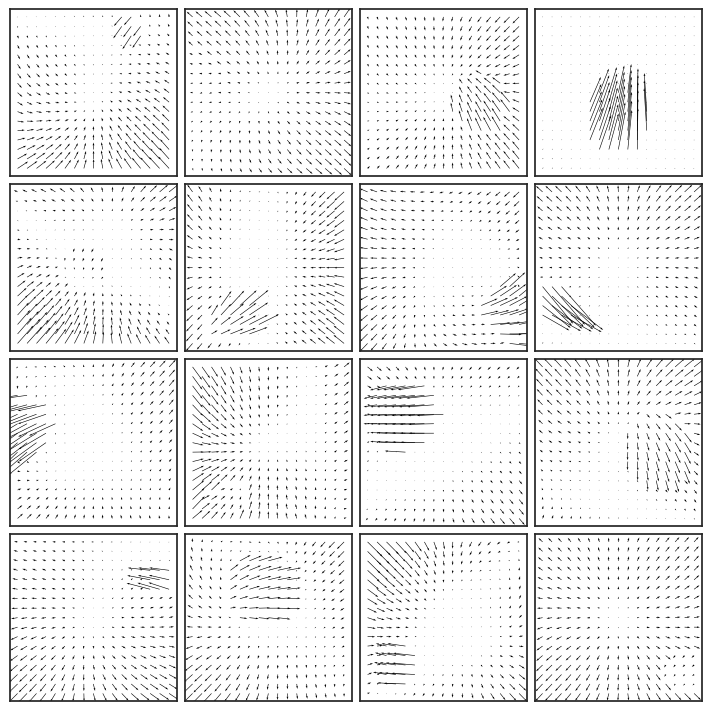

In [21]:
x, _ = next(iter(tr.dl_tst))
x = x[:16]

show_opticflow(x);

In [23]:
%%time

z, ftr, y, q, p = tr.model.xtract_ftr(x, lesion_enc=None)

In [70]:
x.shape, y.shape, len(z)

(torch.Size([16, 2, 17, 17]), torch.Size([16, 2, 17, 17]), 35)

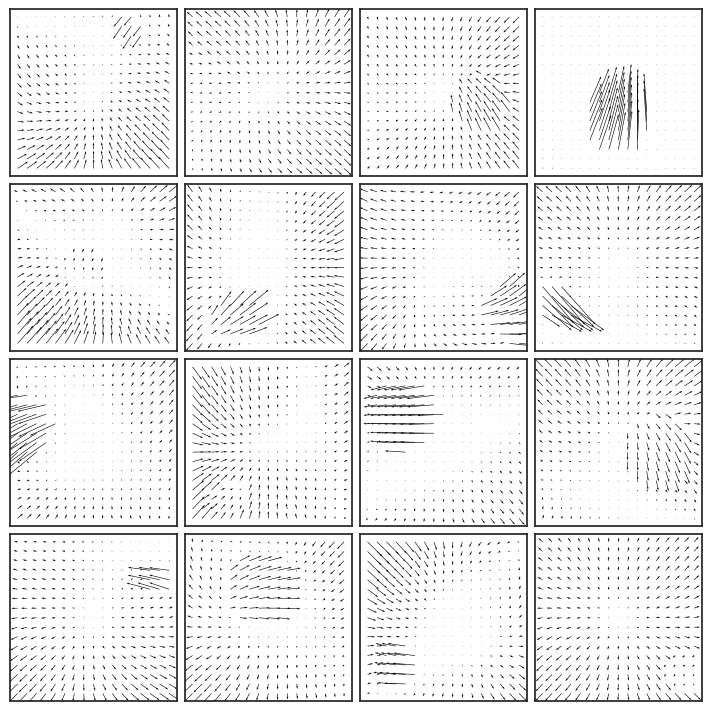

In [69]:
show_opticflow(y);

### Plot a latent

In [55]:
x2p = to_np(z[-1])

sample_i, latent_i = 2, 0
x2p = x2p[sample_i, latent_i]
x2p.shape

(8, 8)

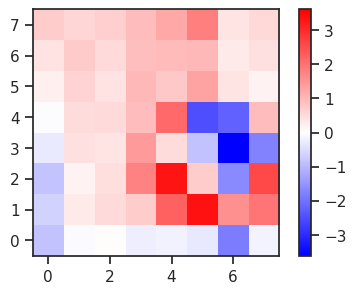

In [59]:
vminmax = np.max(np.abs(x2p))
kws2p = dict(
    cmap='bwr',
    vmax=vminmax,
    vmin=-vminmax,
)
fig, ax = create_figure()
im = ax.imshow(x2plt[2, 0], **kws2p)
plt.colorbar(im, ax=ax)
ax.invert_yaxis()
plt.show()

## Lesion

In [64]:
scales, _ = tr.model.latent_scales()
collections.Counter(scales), len(scales)

(Counter({2: 5, 4: 10, 8: 20}), 35)

In [65]:
lesion = {
    s: [s == item for item in scales]
    for s in np.unique(scales)
}

In [101]:
%%time

results_enc, results_z = {}, {}
for k, v in lesion.items():
    results_enc[k] = tr.model.xtract_ftr(
        x=x, lesion_enc=v)[2]
    results_z[k] = tr.model.xtract_ftr(
        x=x, lesion=v)[2]

CPU times: user 1h 6min 47s, sys: 6.66 s, total: 1h 6min 54s
Wall time: 5min 27s


### Plot: enc lesion

In [102]:
results2plot = torch.stack([x] + list(results_enc.values()))
results2plot.shape

torch.Size([4, 16, 2, 17, 17])

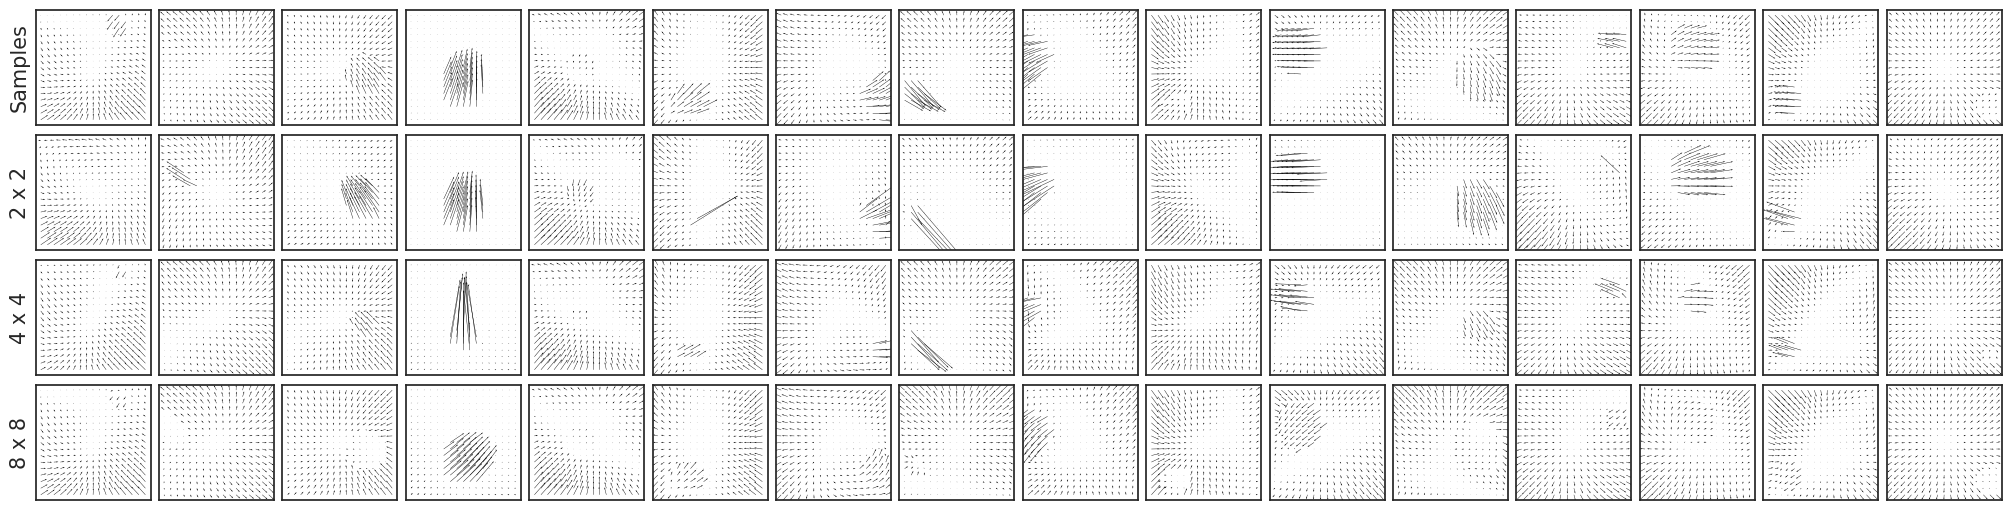

In [103]:
fig, axes = show_opticflow_row(results2plot, figsize=(20, 5), display=False)

axes[0, 0].set_ylabel('Samples', fontsize=15)
for i, s in enumerate(lesion, start=1):
    axes[i, 0].set_ylabel(f'{s} x {s}', fontsize=15)

display(fig)

### Plot: z lesion

In [104]:
results2plot = torch.stack([x] + list(results_z.values()))
results2plot.shape

torch.Size([4, 16, 2, 17, 17])

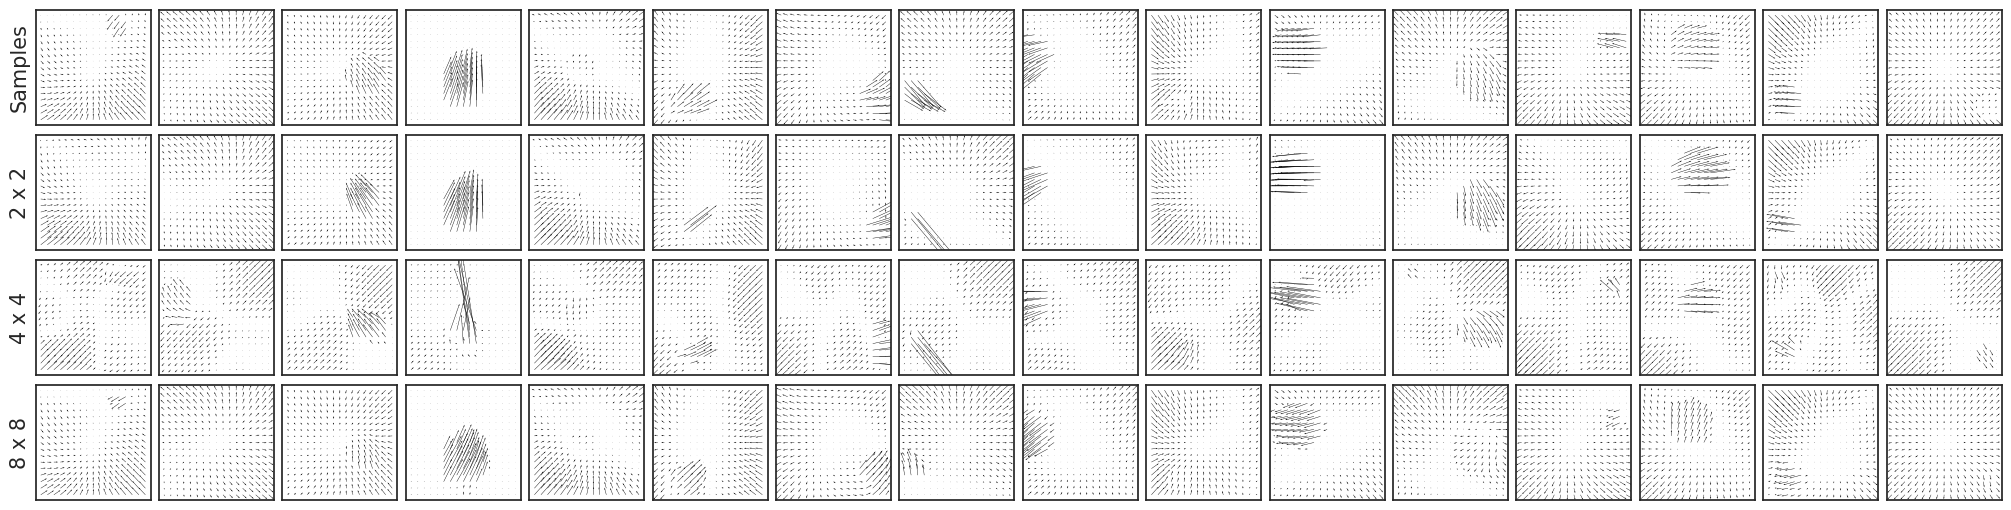

In [105]:
fig, axes = show_opticflow_row(results2plot, figsize=(20, 5), display=False)

axes[0, 0].set_ylabel('Samples', fontsize=15)
for i, s in enumerate(lesion, start=1):
    axes[i, 0].set_ylabel(f'{s} x {s}', fontsize=15)

display(fig)